In [1]:
import sys
import time
import warnings

sys.path.insert(0,"..")

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

rng = np.random.RandomState(69)
tf.random.set_seed(69)
plt.style.use("seaborn")
warnings.filterwarnings("ignore")
gpflow.config.set_default_float(np.float64)

/Users/oskar/source/python/orthogonal-SVGP/notebooks/../gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


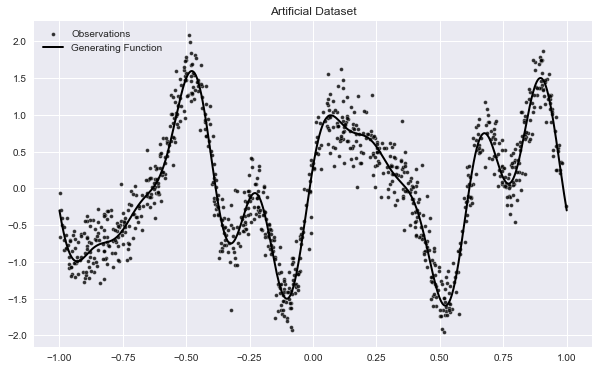

In [2]:
def func(x):
    return np.sin(x*3* np.pi) + 0.3*np.cos(x*9*np.pi) + 0.5*np.sin(x*7*np.pi)

# Number of training observations and noise scale
N = 1000
sigma_n = 0.25

# Inputs and (noisy) outputs
X = rng.rand(N, 1) * 2 - 1 
y = func(X) + sigma_n * rng.randn(N, 1) 
data = (X, y)

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(np.linspace(-1.0, 1.0, 1000), func(np.linspace(-1.0, 1.0, 1000)), lw=2, 
        label="Generating Function", c="k")
ax.set_title("Artificial Dataset")
ax.legend()
plt.show()

In [3]:
# Initialise inducing points
M1 = 10
M2 = 5
Z = rng.rand(M1, 1)
O = rng.rand(M2, 1) - 1

# Set kernel
kernel = gpflow.kernels.SquaredExponential()

# Initialise the SGPR model
osgpr = gpflow.models.OSGPR(data, kernel, Z, O, noise_variance=sigma_n**2)

In [11]:
# print(osgpr.kernel(osgpr.inducing_variable_1.Z, osgpr.inducing_variable_2.Z))
print(osgpr.kernel(osgpr.inducing_variable_1.Z, osgpr.inducing_variable_1.Z))

tf.Tensor(
[[1.34163804e-070 1.36019228e-059 1.74614352e-122 2.82695909e-101
  2.36064347e-049]
 [1.02515886e-019 2.48121727e-014 9.53333017e-050 9.34982820e-037
  7.92779339e-010]
 [1.95440242e-035 6.97377819e-028 6.75822192e-074 9.79840359e-058
  3.63132989e-021]
 [4.88576924e-006 1.16364273e-003 2.21843795e-024 8.75715815e-016
  3.18391566e-002]
 [3.00539991e-027 9.67069828e-021 1.19788790e-061 5.15744994e-047
  4.32695889e-015]
 [2.81677346e-064 8.23087947e-054 4.61656257e-114 1.21299013e-093
  4.01569720e-044]
 [2.93084719e-009 5.93879327e-006 3.23406125e-031 2.91848886e-021
  1.44318665e-003]
 [3.97929081e-014 9.66100991e-010 2.81971362e-040 9.59512263e-029
  2.95670105e-006]
 [2.48804647e-054 8.97197754e-045 1.38853439e-100 1.71364612e-081
  5.17963070e-036]
 [6.81753651e-045 2.78505562e-036 1.80675339e-087 9.24220077e-070
  1.74355583e-028]], shape=(10, 5), dtype=float64)
tf.Tensor(
[[8.80170572e-02 2.84923469e-18 5.27705225e-08 1.25397139e-40
  2.44126184e-12 6.19850115e-02 1.

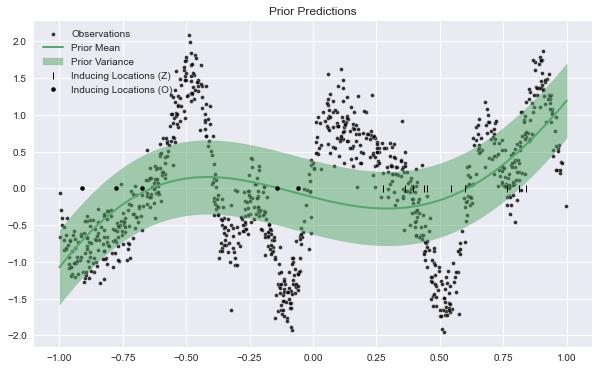

In [4]:
# Prior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
osgpr_prior_mean, osgpr_prior_var = osgpr.predict_y(X_pred)
Z = osgpr.inducing_variable_1.Z.numpy()
O = osgpr.inducing_variable_2.Z.numpy()

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], osgpr_prior_mean[:, 0], c="C1", lw=2, label="Prior Mean")
ax.fill_between(X_pred[:, 0], osgpr_prior_mean[:, 0] + 2*np.sqrt(osgpr_prior_var[:, 0]), 
                osgpr_prior_mean[:, 0] - 2*np.sqrt(osgpr_prior_var[:, 0]), color="C1", 
                alpha=0.5, label="Prior Variance")
ax.plot(Z, np.zeros_like(Z), "k|", mew=1, label="Inducing Locations (Z)")
ax.plot(O, np.zeros_like(O), "k.", mew=1, label="Inducing Locations (O)")
ax.set_title("Prior Predictions")
ax.legend()
plt.show()

In [5]:
print(osgpr.elbo())
optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(osgpr.training_loss, 
                   osgpr.trainable_variables,
                   options={"maxiter": 1000, "disp": False})                 
print(osgpr.elbo())

tf.Tensor(-4393.687602514422, shape=(), dtype=float64)


2022-07-11 17:20:11.748927: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-11 17:20:13.988176: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(-260.5677007904683, shape=(), dtype=float64)


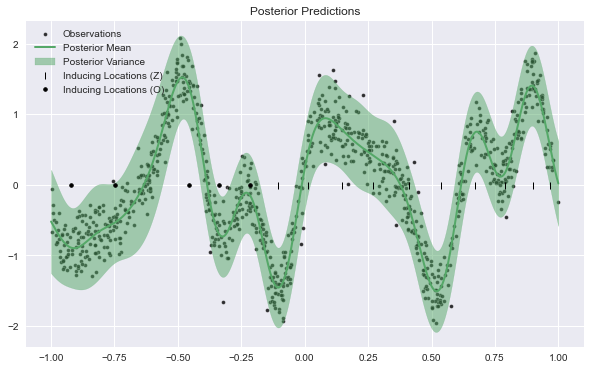

In [6]:
# Posterior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
osgpr_post_mean, osgpr_post_var = osgpr.predict_y(X_pred)
Z = osgpr.inducing_variable_1.Z.numpy()
O = osgpr.inducing_variable_2.Z.numpy()

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], osgpr_post_mean[:, 0], c="C1", lw=2, label="Posterior Mean")
ax.fill_between(X_pred[:, 0], osgpr_post_mean[:, 0] + 2*np.sqrt(osgpr_post_var[:, 0]), 
                osgpr_post_mean[:, 0] - 2*np.sqrt(osgpr_post_var[:, 0]), color="C1", 
                alpha=0.5, label="Posterior Variance")
ax.plot(Z, np.zeros_like(Z), "k|", mew=1, label="Inducing Locations (Z)")
ax.plot(O, np.zeros_like(O), "k.", mew=1, label="Inducing Locations (O)")
ax.set_title("Posterior Predictions")
ax.legend()
plt.show()

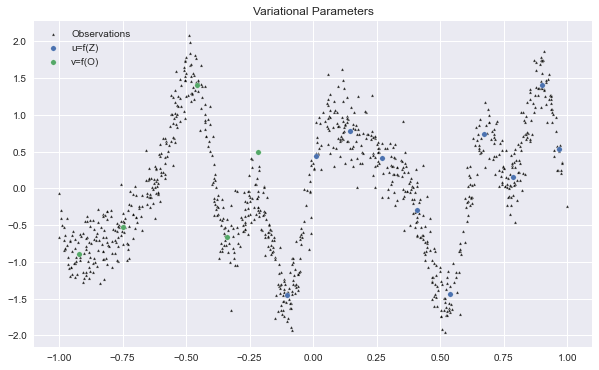

In [8]:
# Variational parameters
mu, Su = osgpr.compute_qu()
mu = mu.numpy().ravel()
Z = osgpr.inducing_variable_1.Z.numpy().ravel()

mv, Sv = osgpr.compute_qv()
mv = mv.numpy().ravel()
O = osgpr.inducing_variable_2.Z.numpy().ravel()

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=10, alpha=0.8, 
           marker="^",label="Observations")
ax.scatter(Z, mu, facecolor="C0", edgecolor="w", s=30, label="u=f(Z)")
ax.scatter(O, mv, facecolor="C1", edgecolor="w", s=30, label="v=f(O)")
ax.set_title("Variational Parameters")
ax.legend()
plt.show()